<a href="https://colab.research.google.com/github/Francescolv99/Deep-Video-Deblurring/blob/main/Deep_Video_Deblurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ottengo il dataset scaricandolo dal link in questione


In [ ]:
!wget http://www.cs.ubc.ca/labs/imager/tr/2017/DeepVideoDeblurring/DeepVideoDeblurring_Dataset.zip
!unzip /content/DeepVideoDeblurring_Dataset.zip

Importo i pacchetti necessari

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import pandas as pd
import os

Creo le variabili x e y e le funzioni necessarie per lavorare il dataset

In [2]:
#dim immagini 720x1280x3
x = []
y = []

def appendImmagine(filename, x):
    im_1 = Image.open(filename)
    ar = np.array(im_1)
    ar = ar[300:452,600:800]
    x.append(ar)
    #x=np.append(x,ar)
    return x
    
#accedo ad ogni immagine nel database e le inserisco in forma matriciale in x e y
def ottieniImmagini(filename, x , y):
    x2 = []
    y2 = []
    #apro la cartella del dataset
    entries = os.listdir(filename)
    #entries.pop(0)
    #apro ogni sottocartella
    print("LOADING DATASET:")
    counter = 0
    for cartella in entries:
      #cartella è per esempio 720p_240fps_1
        #print(cartella)
        if(cartella==".DS_Store" or cartella=="IMG_0051" or cartella=="IMG_0053" or cartella=="IMG_0049"):
              continue
        counter+=1
        print(str(counter)+"/68 "+"Carico " + cartella)
        x, y = ottieniImmaginiCartella(filename + '/' + cartella,x,y)
        lunghezza = len(x)
        x = np.array(x)
        y = np.array(y)
        i = 0
        while i<lunghezza:
          x2.append(x[i])
          y2.append(y[i])
          i+=1
        x=[]
        y=[]
    x2 = np.array(x2)
    y2 = np.array(y2)
    print("Caricamento completato")
    return x2, y2

def ottieniImmaginiCartella(filename,x, y):
    #apro la cartella del dataset
    entries = os.listdir(filename)
    #entries.pop(0)
    #apro ogni sottocartella
    for cartella in entries:
        if(cartella=="input"):
            lista_immagini = os.listdir(filename + '/' + cartella)
            a = 0
            for immagine in lista_immagini:
                if a==40:
                    break
                if(immagine==".DS_Store"): 
                    continue
                x = appendImmagine(filename + '/' + cartella + '/' + immagine, x)
                a+=1
        elif(cartella==".DS_Store"):
          continue
        else:
            lista_immagini = os.listdir(filename + '/' + cartella)
            b = 0
            for immagine in lista_immagini:
                if b==40:
                    break
                if(immagine==".DS_Store"): 
                    continue
                y = appendImmagine(filename + '/' + cartella + '/' + immagine, y)
                b+=1
    return x, y

In [3]:
#68 cartelle
x, y = ottieniImmagini('/content/DeepVideoDeblurring_Dataset/quantitative_datasets', x , y)

LOADING DATASET:
1/68 Carico IMG_0028
2/68 Carico GOPR9645
3/68 Carico IMG_0019
4/68 Carico IMG_0017
5/68 Carico IMG_0035
6/68 Carico IMG_0033
7/68 Carico IMG_0038
8/68 Carico C0041
9/68 Carico IMG_0164
10/68 Carico IMG_0011
11/68 Carico IMG_0003
12/68 Carico IMG_0024
13/68 Carico IMG_0030
14/68 Carico IMG_0047
15/68 Carico IMG_0034
16/68 Carico IMG_0013
17/68 Carico IMG_0005
18/68 Carico IMG_0021
19/68 Carico IMG_0032
20/68 Carico IMG_0173
21/68 Carico GOPR9643
22/68 Carico GOPR9642
23/68 Carico IMG_0010
24/68 Carico IMG_0200
25/68 Carico GOPR9636
26/68 Carico IMG_0150
27/68 Carico C0036
28/68 Carico GOPR9633
29/68 Carico IMG_0040
30/68 Carico IMG_0031
31/68 Carico IMG_0014
32/68 Carico 720p_240fps_5
33/68 Carico IMG_0029
34/68 Carico GOPR9652
35/68 Carico IMG_0045
36/68 Carico IMG_0004
37/68 Carico IMG_0180
38/68 Carico IMG_0044
39/68 Carico IMG_0009
40/68 Carico IMG_0023
41/68 Carico IMG_0055
42/68 Carico IMG_0015
43/68 Carico IMG_0151
44/68 Carico IMG_0043
45/68 Carico IMG_0183
46/

In [4]:
print(np.shape(x),np.shape(y))

(2715, 152, 200, 3) (2715, 152, 200, 3)


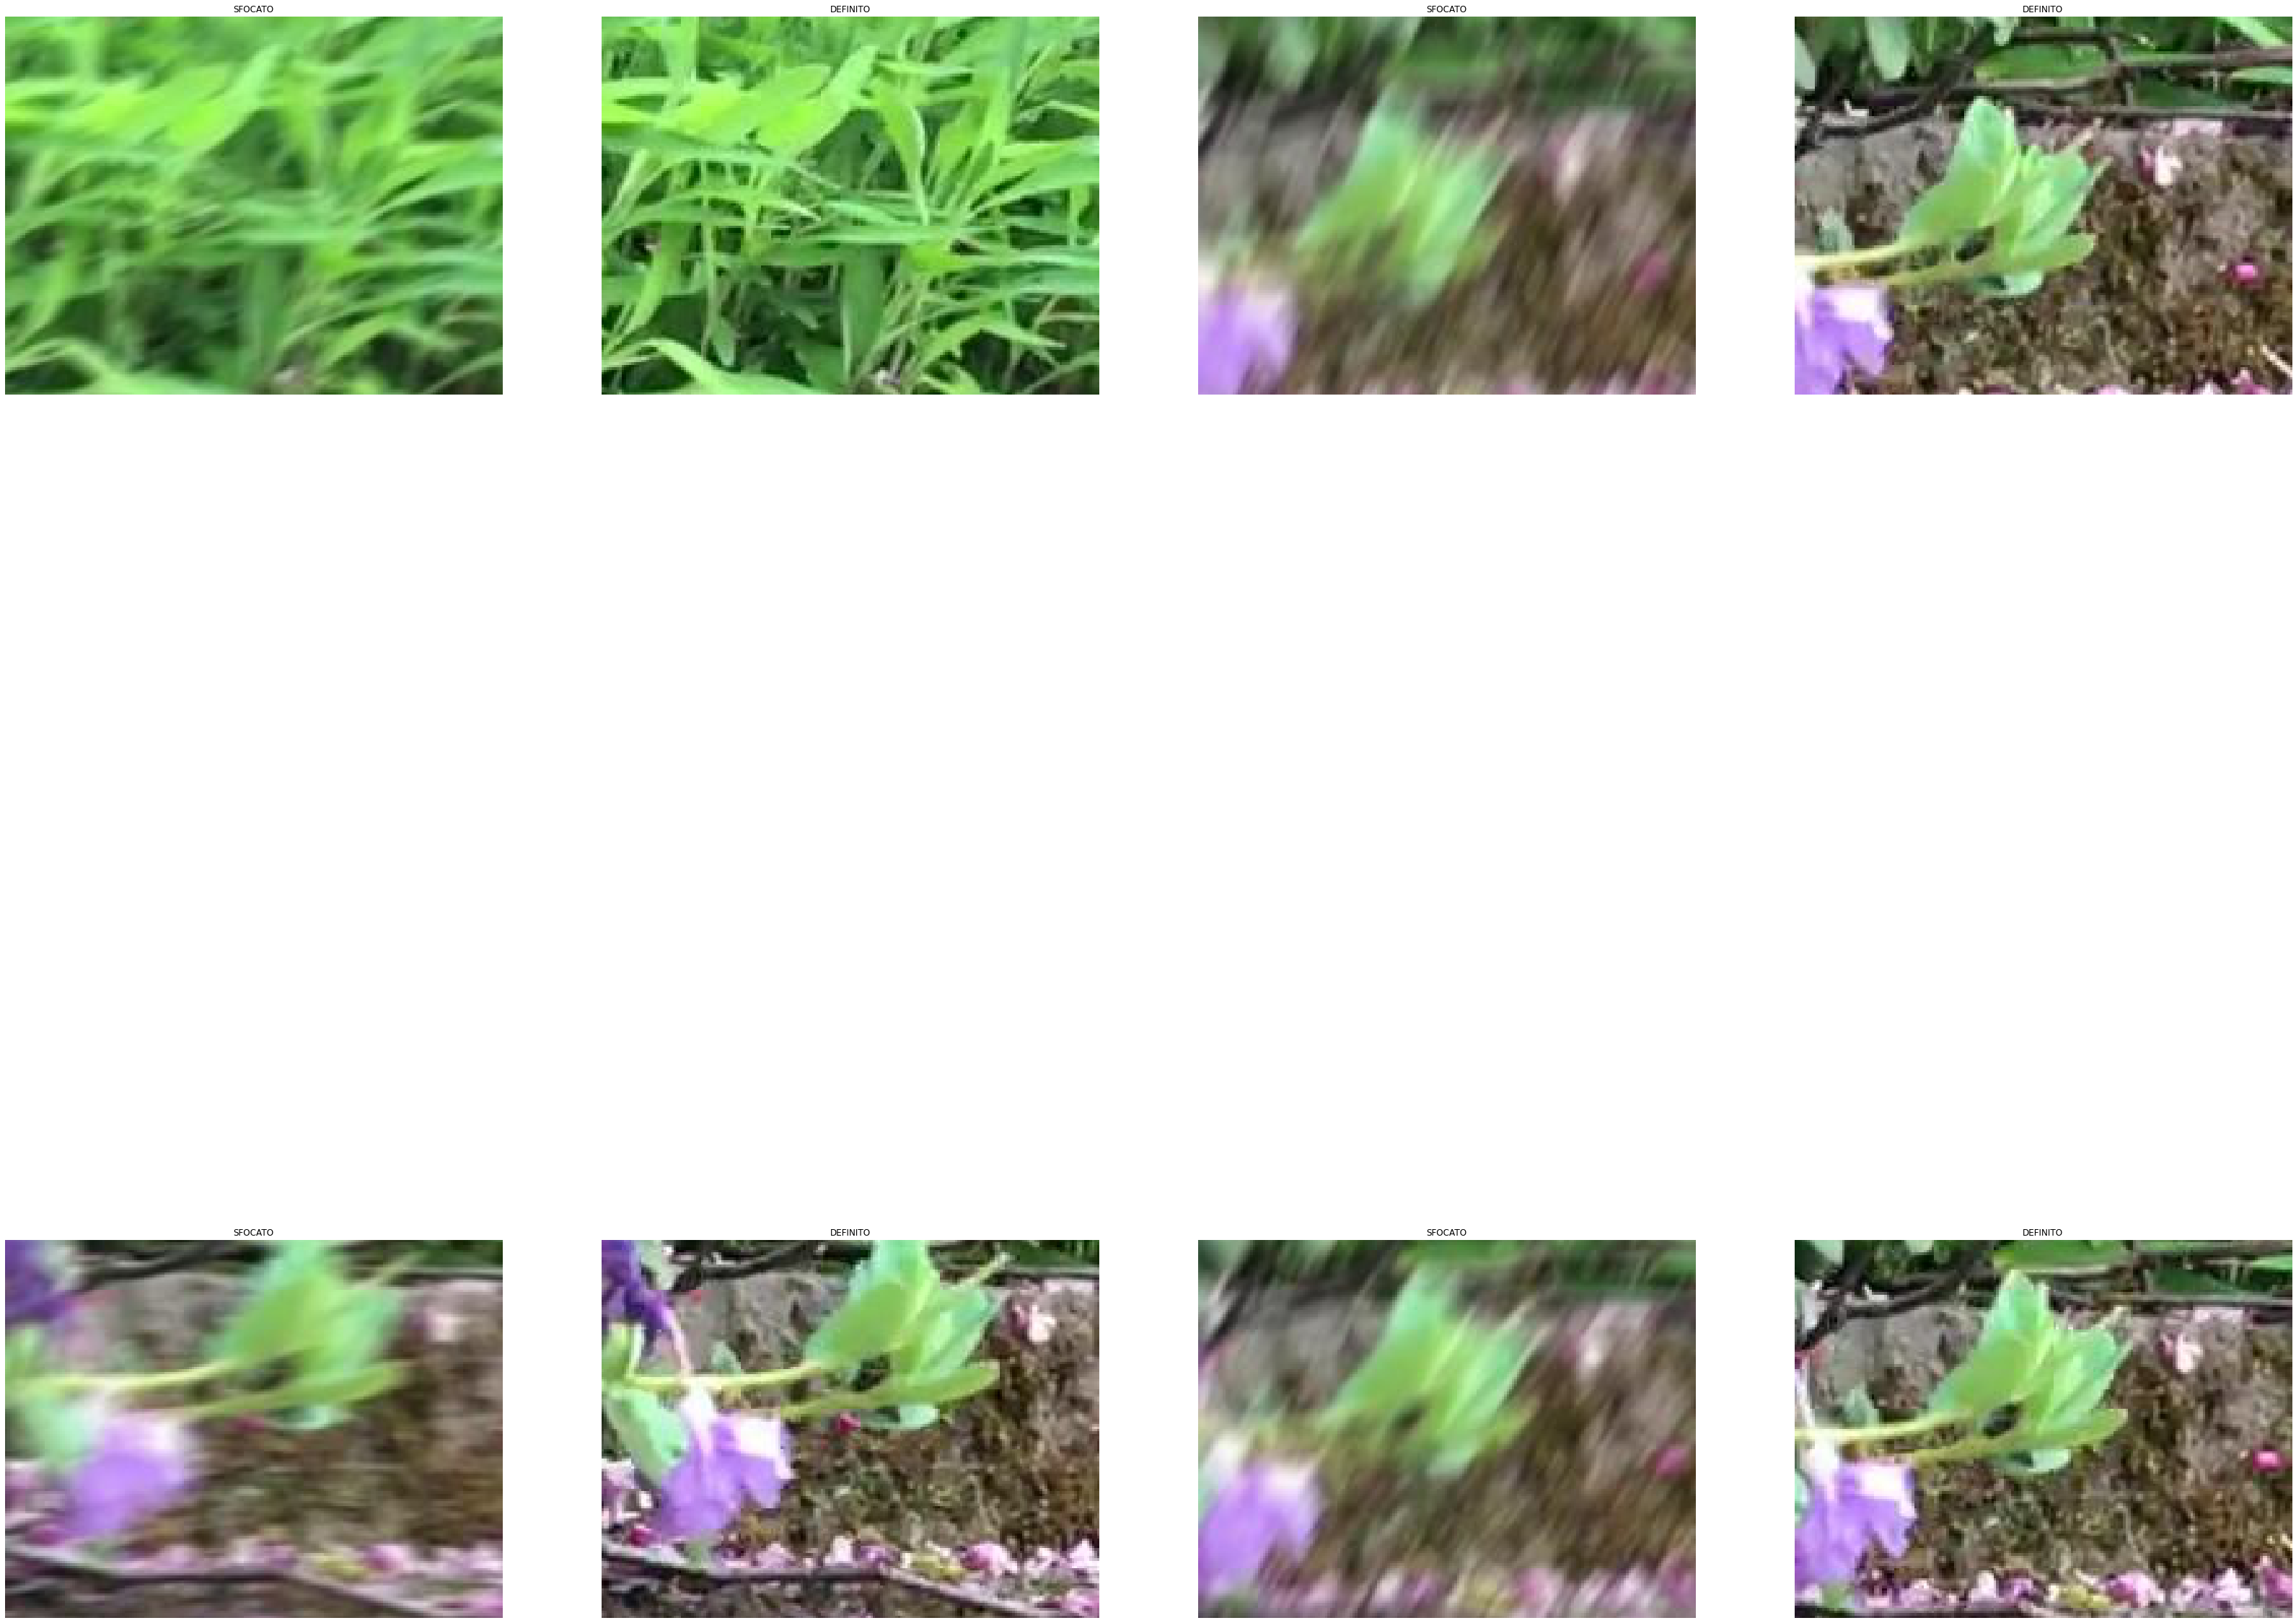

In [5]:
#cerca un modo per stampare meglio queste immagini

import matplotlib.pyplot as plt

n_rows = 2
n_cols = 2


plt.figure(figsize=(n_cols * 28.4, n_rows * 28.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = 2*(n_cols * row + col)
        plt.subplot(n_rows, 2*n_cols, index + 1)
        plt.title("SFOCATO")
        plt.imshow(x[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.subplot(n_rows, 2*n_cols, index + 2)
        plt.title("DEFINITO")
        plt.imshow(y[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        #ingrandire titolo e migliorare stampa immagini
        
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
#normaliziamo l'input tra 0 e 1

x_train = x_train/255
y_train = y_train/255
x_test = x_test/255
y_test = y_test/255

del x
del y

In [7]:
model = keras.models.Sequential()
#encode
model.add(keras.layers.Conv2D(64, (2, 2), strides = 1, padding = 'same', input_shape = (152, 200, 3)))
model.add(keras.layers.Conv2D(32, (2, 2), strides = 1, padding = 'same'))
model.add(keras.layers.Conv2D(16, (2, 2), strides = 1, padding = 'same'))
#latent
model.add(keras.layers.Conv2D(8, (2, 2), strides = 1, padding = 'same'))
#decode
model.add(keras.layers.Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same'))
model.add(keras.layers.Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same'))
model.add(keras.layers.Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same'))
model.add(keras.layers.Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same'))

model.compile(loss="mse",
              optimizer='adam',
              metrics=["mse"]) #mse anzichè accuracy
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 152, 200, 64)      832       
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 200, 32)      8224      
                                                                 
 conv2d_2 (Conv2D)           (None, 152, 200, 16)      2064      
                                                                 
 conv2d_3 (Conv2D)           (None, 152, 200, 8)       520       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 152, 200, 16)     528       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 152, 200, 32)     2080      
 ranspose)                                              

In [8]:
# train the model
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=50,
    batch_size=128,
    verbose = 1,
    #shuffle=True,
    validation_data=(x_test, y_test),
)


Epoch 1/50
17/17 [==============================] - 34s 1s/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 2/50
17/17 [==============================] - 14s 849ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 3/50
17/17 [==============================] - 15s 862ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 4/50
17/17 [==============================] - 15s 875ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 5/50
17/17 [==============================] - 15s 892ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 6/50
17/17 [==============================] - 15s 887ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 7/50
17/17 [==============================] - 15s 881ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 8/50
17/17 [==============================] - 15s 874ms/step - los

17/17 - 2s - loss: 0.0028 - mse: 0.0028 - 2s/epoch - 106ms/step
mse: 0.28%


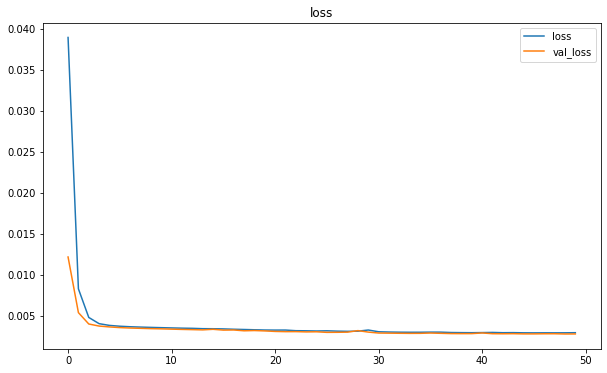

In [9]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'], label='loss')
  plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
  plt.title('loss')
  plt.legend()
def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['mse'],label='mse')
  plt.plot(history.epoch,history.history['val_mse'],label='val_mse')
  plt.title('mse')
  plt.legend()

plot_loss(history)

#plot_accuracy(history)

scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

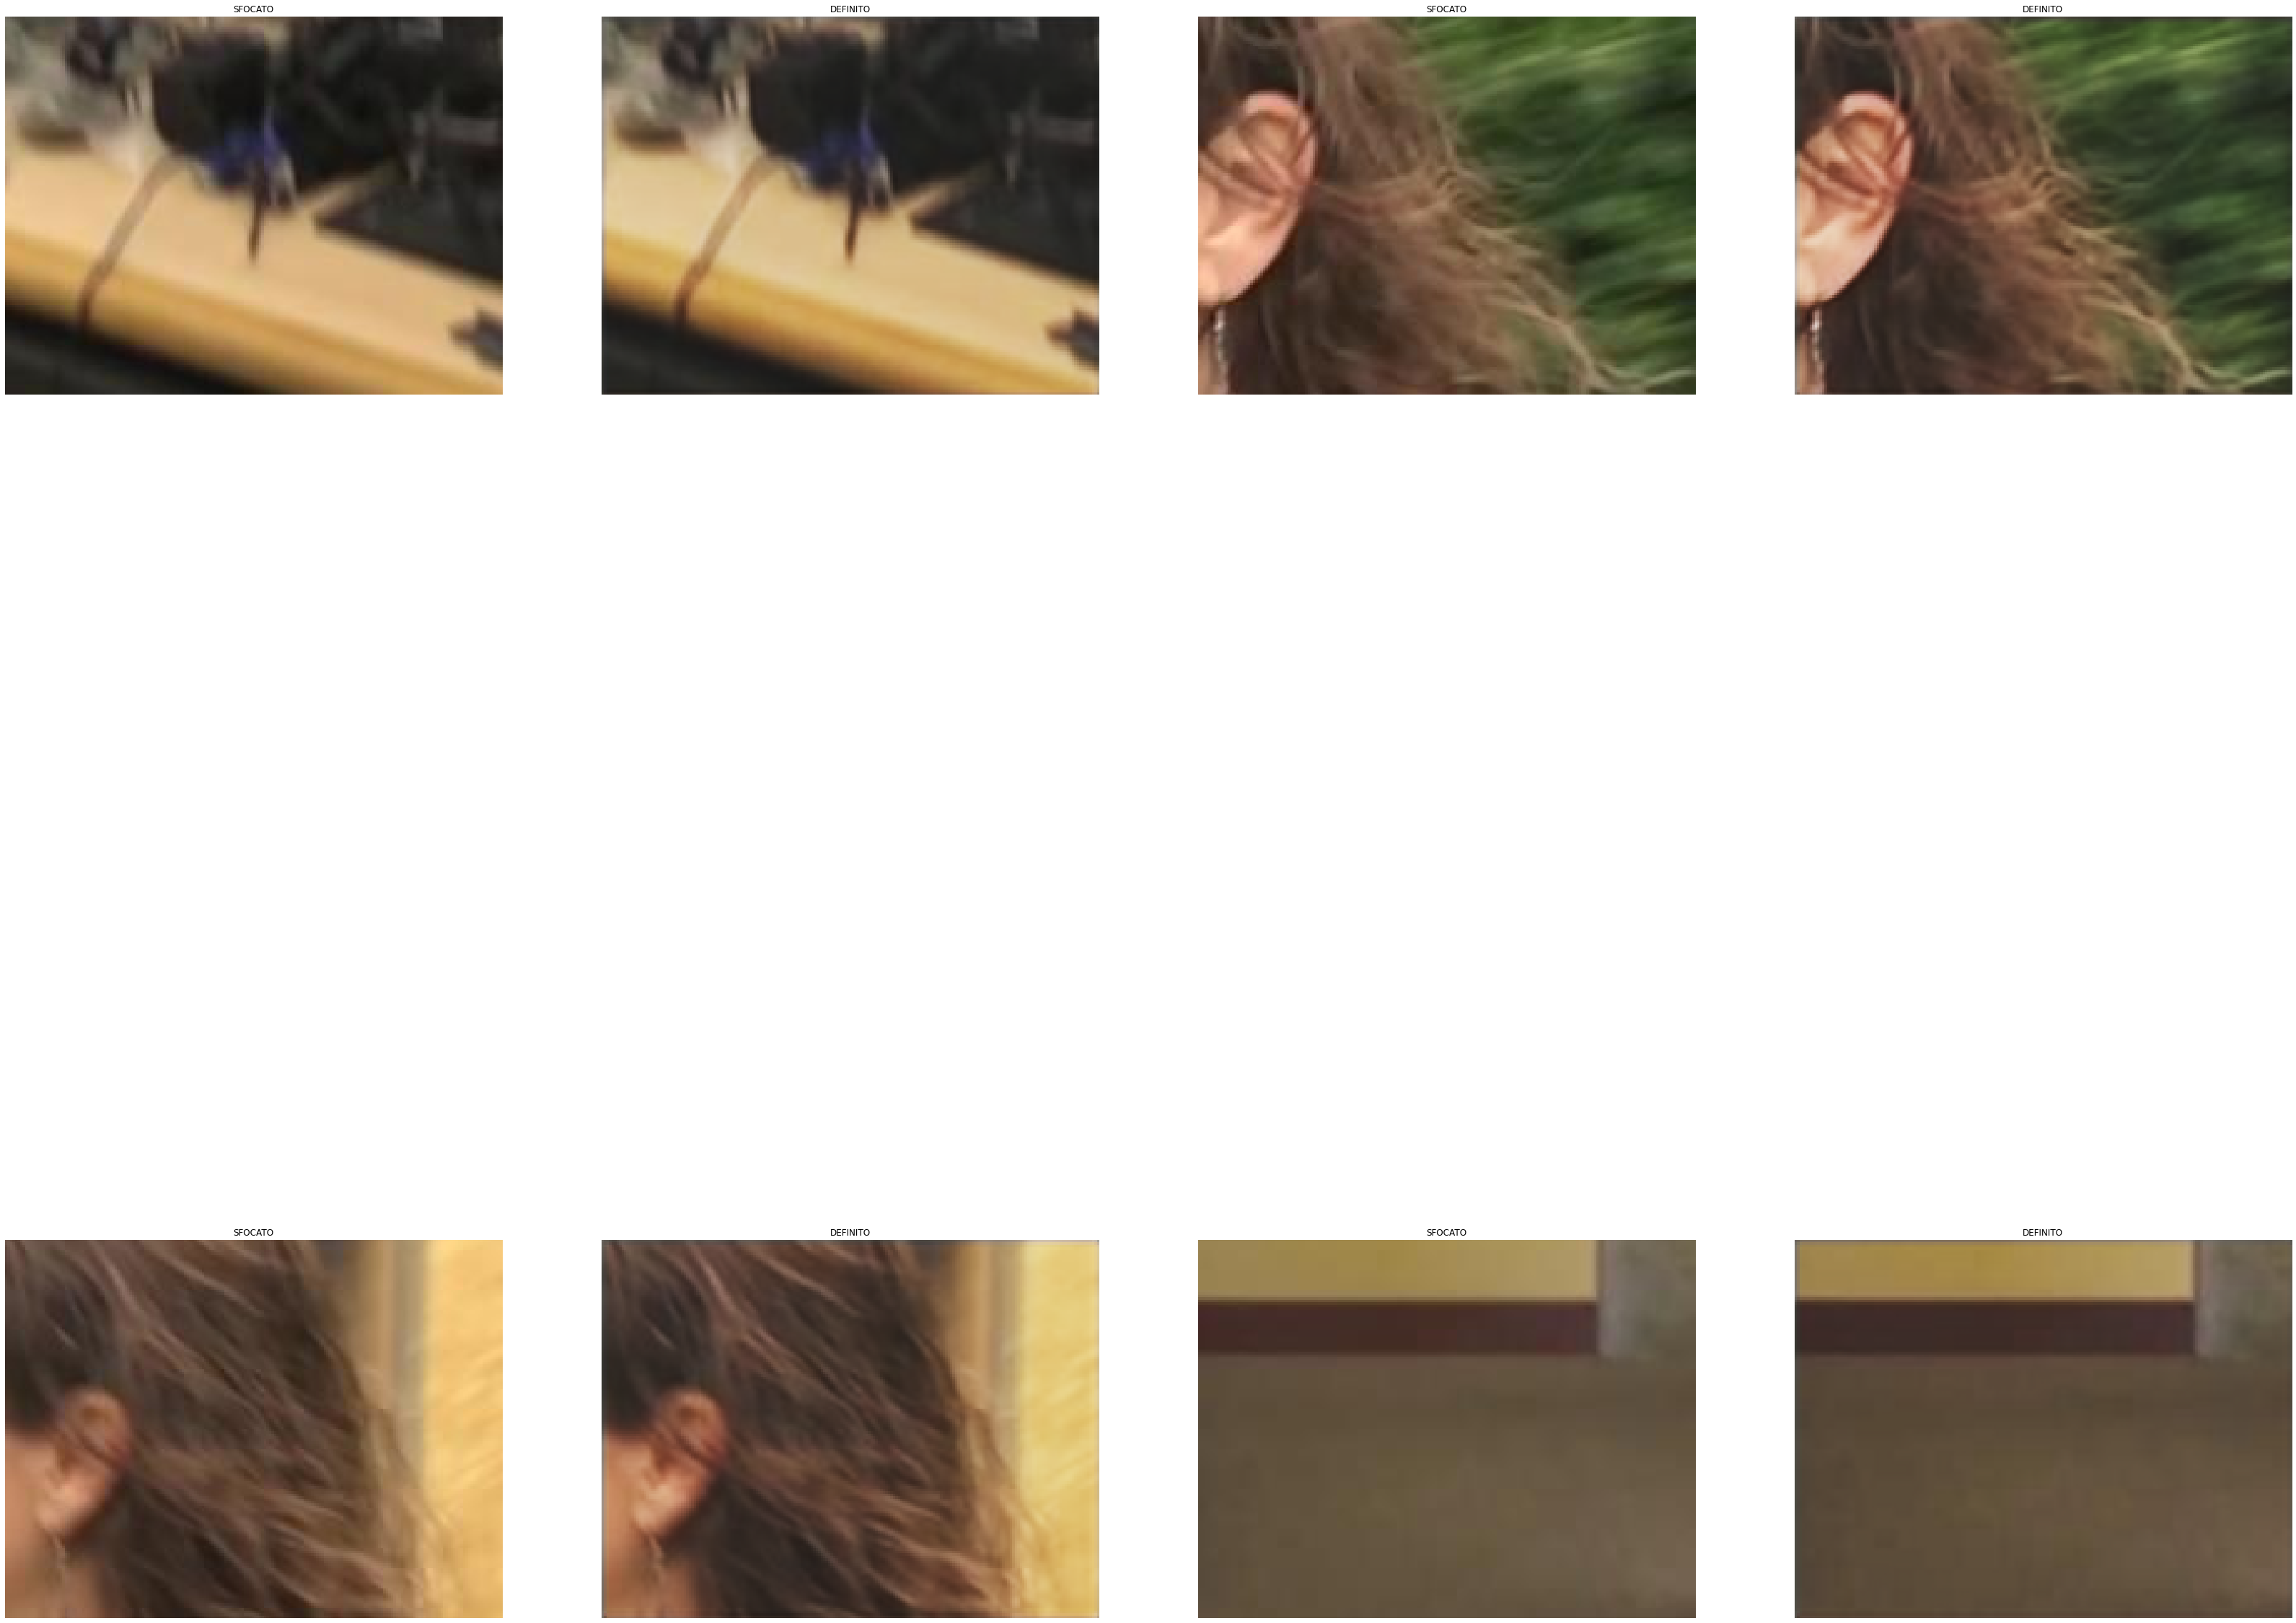

In [10]:
# mostrarere di nuovo le immagini correte dalla mia rete neurale rispetto a quelle vere
decoded_imgs = model.predict(x_test)

n_rows = 2
n_cols = 2


plt.figure(figsize=(n_cols * 28.4, n_rows * 28.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = 2*(n_cols * row + col)
        plt.subplot(n_rows, 2*n_cols, index + 1)
        plt.title("SFOCATO")
        plt.imshow(x_test[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.subplot(n_rows, 2*n_cols, index + 2)
        plt.title("DEFINITO")
        plt.imshow(decoded_imgs[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        #ingrandire titolo e migliorare stampa immagini
        
plt.show()